Combined plot saved for scenario 6ac-10000-superdiverse at ../2-archive-runs/11-run/6ac-10000-superdiverse/plots/averaged_rewards_over_steps_6ac-10000-superdiverse.png


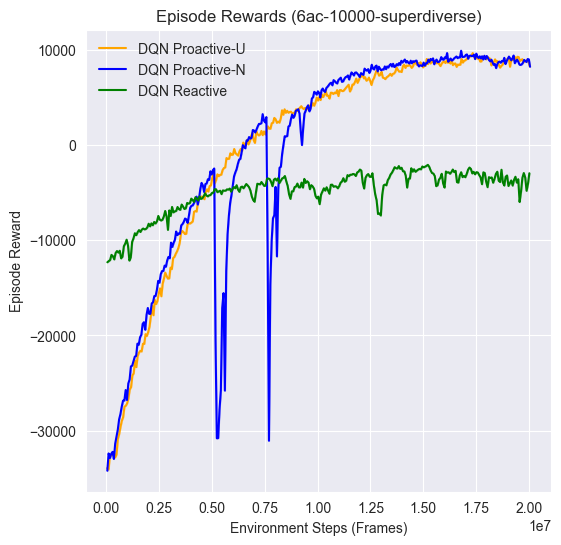

all seeds: {2020}


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import seaborn as sns
sns.set_style("darkgrid")

###################################
# User parameters
###################################
master_folders = ["../2-archive-runs"]  # List of master folders to process
target_folder = "11-run"
target_scenario = "6ac-10000-superdiverse"
shown_seeds = []  # Only show these seeds, empty list means show all seeds
SMOOTHEDING_WINDOW = 1

###################################

def smooth(data, window=4):
    """Apply a simple moving average smoothing."""
    if isinstance(data, (float, np.float64)):
        return data
    if window > 1 and len(data) >= window:
        return np.convolve(data, np.ones(window)/window, mode='valid')
    return data

# Loop through each master folder
for master_folder in master_folders:
    if not os.path.exists(master_folder):
        print(f"Skipping - The master folder '{master_folder}' does not exist.")
        continue

    save_folder = os.path.join(master_folder, target_folder)
    if not os.path.exists(save_folder):
        print(f"Target folder '{save_folder}' does not exist.")
        continue

    scenario_path = os.path.join(save_folder, target_scenario)
    numpy_path = os.path.join(scenario_path, "numpy")

    if not os.path.exists(numpy_path):
        print(f"Skipping {target_scenario} - no numpy folder found")
        continue

    # Find all numpy files in the directory
    numpy_files = [f for f in os.listdir(numpy_path) if f.endswith('.npy')]
    
    if not numpy_files:
        print(f"No .npy files found in {numpy_path}")
        continue

    # Create plots directory
    plots_dir = f"{scenario_path}/plots"
    os.makedirs(plots_dir, exist_ok=True)
        
    # Create figure
    plt.figure(figsize=(6,6))
        
    # Group files by agent type
    agent_data = {}
    test_data = {}
    colors = {'proactive': 'orange', 'myopic': 'blue', 'reactive': 'green', 'drl-greedy': 'red'}
    labels = {
        'proactive': 'DQN Proactive-U',
        'myopic': 'DQN Proactive-N', 
        'reactive': 'DQN Reactive'
    }
    
    # Process training data
    for file in numpy_files:
        if 'test_rewards' in file:
            continue
            
        if 'runs_seed_' in file and not 'steps' in file:
            agent_type = file.split('_runs_seed_')[0]
            data_type = 'runs'
        elif 'steps_runs_seed_' in file:
            agent_type = file.split('_steps_runs_seed_')[0]
            data_type = 'steps'
        else:
            continue
            
        if agent_type not in agent_data:
            agent_data[agent_type] = {'runs': [], 'steps': [], 'seeds': set()}
            
        data = np.load(os.path.join(numpy_path, file))
        seed = int(file.split('_seed_')[1].split('.')[0])
        
        # Skip if seed not in shown_seeds (if shown_seeds is not empty)
        if shown_seeds and seed not in shown_seeds:
            continue
            
        if data_type == 'runs':
            agent_data[agent_type]['runs'].append(data)
        else:
            agent_data[agent_type]['steps'].append(data)
        agent_data[agent_type]['seeds'].add(seed)

    # Plot training data in specified order
    plot_order = ['proactive', 'myopic', 'reactive']
    for agent_type in plot_order:
        if agent_type not in agent_data:
            continue
            
        data = agent_data[agent_type]
        if len(data['runs']) == 0 or len(data['steps']) == 0:
            print(f"Skipping {agent_type} - missing runs or steps data")
            continue
            
        # Find minimum length and truncate arrays
        min_length = min(len(run) for run in data['runs'])
        runs_array = np.array([run[:min_length] for run in data['runs']])
        steps_array = np.array([steps[:min_length] for steps in data['steps']])

        # Calculate statistics
        mean = runs_array.mean(axis=0)
        std = runs_array.std(axis=0)
        steps_mean = steps_array.mean(axis=0).astype(int)

        # Apply smoothing
        smooth_window = SMOOTHEDING_WINDOW
        mean_sm = smooth(mean, smooth_window)
        std_sm = smooth(std, smooth_window)
        steps_sm = steps_mean[:len(mean_sm)]

        plt.plot(steps_sm, mean_sm, label=labels.get(agent_type, agent_type.capitalize()), color=colors.get(agent_type, 'gray'))
        plt.fill_between(steps_sm,
                        mean_sm - std_sm,
                        mean_sm + std_sm,
                        alpha=0.2, color=colors.get(agent_type, 'gray'))

    plt.xlabel("Environment Steps (Frames)")
    plt.ylabel("Episode Reward")
    plt.title(f"Episode Rewards ({target_scenario})")
    plt.legend(frameon=False)
    plt.grid(True)

    plot_file = os.path.join(plots_dir, f"averaged_rewards_over_steps_{target_scenario}.png")
    plt.savefig(plot_file)
    print(f"Combined plot saved for scenario {target_scenario} at {plot_file}")
    plt.show()
    print(f"all seeds: {data['seeds']}")

Combined plot saved for scenario 6ac-10000-superdiverse at ../2-archive-runs/11-run/6ac-10000-superdiverse/plots/averaged_rewards_over_steps_6ac-10000-superdiverse.png


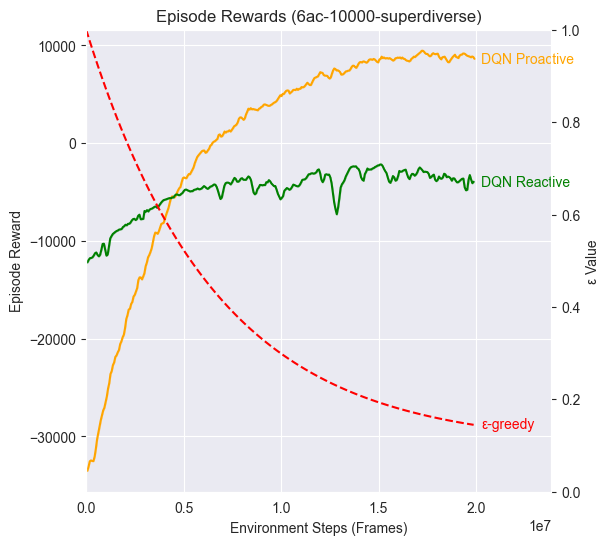

all seeds: {2020}


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import seaborn as sns
sns.set_style("darkgrid")

###################################
# User parameters
###################################
master_folders = ["../2-archive-runs"]  # List of master folders to process
target_folder = "11-run"
target_scenario = "6ac-10000-superdiverse"
shown_seeds = []  # Only show these seeds, empty list means show all seeds
SMOOTHEDING_WINDOW = 3

###################################

def smooth(data, window=4):
    """Apply a simple moving average smoothing."""
    if isinstance(data, (float, np.float64)):
        return data
    if window > 1 and len(data) >= window:
        return np.convolve(data, np.ones(window)/window, mode='valid')
    return data

# Loop through each master folder
for master_folder in master_folders:
    if not os.path.exists(master_folder):
        print(f"Skipping - The master folder '{master_folder}' does not exist.")
        continue

    save_folder = os.path.join(master_folder, target_folder)
    if not os.path.exists(save_folder):
        print(f"Target folder '{save_folder}' does not exist.")
        continue

    scenario_path = os.path.join(save_folder, target_scenario)
    numpy_path = os.path.join(scenario_path, "numpy")

    if not os.path.exists(numpy_path):
        print(f"Skipping {target_scenario} - no numpy folder found")
        continue

    # Find all numpy files in the directory
    numpy_files = [f for f in os.listdir(numpy_path) if f.endswith('.npy')]
    
    if not numpy_files:
        print(f"No .npy files found in {numpy_path}")
        continue

    # Create plots directory
    plots_dir = f"{scenario_path}/plots"
    os.makedirs(plots_dir, exist_ok=True)
        
    # Create figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(6,6))
    ax2 = ax1.twinx()
    ax2.grid(False)  # Turn off grid for second axis
        
    # Group files by agent type
    agent_data = {}
    test_data = {}
    colors = {'proactive': 'orange', 'reactive': 'green'}
    labels = {
        'proactive': 'DQN Proactive',
        'reactive': 'DQN Reactive'
    }
    
    # Process training data
    for file in numpy_files:
        if 'test_rewards' in file:
            continue
            
        if 'runs_seed_' in file and not 'steps' in file:
            agent_type = file.split('_runs_seed_')[0]
            data_type = 'runs'
        elif 'steps_runs_seed_' in file:
            agent_type = file.split('_steps_runs_seed_')[0]
            data_type = 'steps'
        else:
            continue
            
        # Skip if not proactive or reactive
        if agent_type not in ['proactive', 'reactive']:
            continue
            
        if agent_type not in agent_data:
            agent_data[agent_type] = {'runs': [], 'steps': [], 'seeds': set()}
            
        data = np.load(os.path.join(numpy_path, file))
        seed = int(file.split('_seed_')[1].split('.')[0])
        
        # Skip if seed not in shown_seeds (if shown_seeds is not empty)
        if shown_seeds and seed not in shown_seeds:
            continue
            
        if data_type == 'runs':
            agent_data[agent_type]['runs'].append(data)
        else:
            agent_data[agent_type]['steps'].append(data)
        agent_data[agent_type]['seeds'].add(seed)

    # Plot training data in specified order
    plot_order = ['proactive', 'reactive']
    final_values = {}  # Store final y-values for labels
    
    for agent_type in plot_order:
        if agent_type not in agent_data:
            continue
            
        data = agent_data[agent_type]
        if len(data['runs']) == 0 or len(data['steps']) == 0:
            print(f"Skipping {agent_type} - missing runs or steps data")
            continue
            
        # Find minimum length and truncate arrays
        min_length = min(len(run) for run in data['runs'])
        runs_array = np.array([run[:min_length] for run in data['runs']])
        steps_array = np.array([steps[:min_length] for steps in data['steps']])

        # Calculate statistics
        mean = runs_array.mean(axis=0)
        std = runs_array.std(axis=0)
        steps_mean = steps_array.mean(axis=0).astype(int)

        # Apply smoothing
        smooth_window = SMOOTHEDING_WINDOW
        mean_sm = smooth(mean, smooth_window)
        std_sm = smooth(std, smooth_window)
        steps_sm = steps_mean[:len(mean_sm)]

        line = ax1.plot(steps_sm, mean_sm, color=colors.get(agent_type, 'gray'))[0]
        ax1.fill_between(steps_sm,
                        mean_sm - std_sm,
                        mean_sm + std_sm,
                        alpha=0.2, color=colors.get(agent_type, 'gray'))
                        
        # Store final y-value for label
        final_values[agent_type] = mean_sm[-1]

    # Add epsilon decay line on second y-axis
    max_steps = max(steps_sm)
    epsilon_steps = np.linspace(0, max_steps, 100)
    epsilon_values = 0.9 * np.exp(-3 * epsilon_steps / max_steps) + 0.1
    ax2.plot(epsilon_steps, epsilon_values, '--', color='red')
    
    # Add labels at the end of each line
    for agent_type in plot_order:
        if agent_type in final_values:
            ax1.text(max_steps + max_steps*0.02, final_values[agent_type], 
                    labels.get(agent_type, agent_type.capitalize()),
                    color=colors.get(agent_type, 'gray'),
                    verticalalignment='center')
    
    # Add epsilon label at its final value        
    ax2.text(max_steps + max_steps*0.02, epsilon_values[-1], 'ε-greedy',
             color='red', verticalalignment='center')
    
    ax1.set_xlabel("Environment Steps (Frames)")
    ax1.set_ylabel("Episode Reward")
    ax2.set_ylabel("ε Value")
    ax2.set_ylim(0, 1)
    
    plt.title(f"Episode Rewards ({target_scenario})")
    
    # Extend x-axis to make room for labels
    ax1.set_xlim(0, max_steps + max_steps*0.2)
    
    ax1.grid(True)

    plot_file = os.path.join(plots_dir, f"averaged_rewards_over_steps_{target_scenario}.png")
    plt.savefig(plot_file)
    print(f"Combined plot saved for scenario {target_scenario} at {plot_file}")
    plt.show()
    print(f"all seeds: {data['seeds']}")

GIF saved at training_curve_6ac-10000-superdiverse-loose-axis.gif


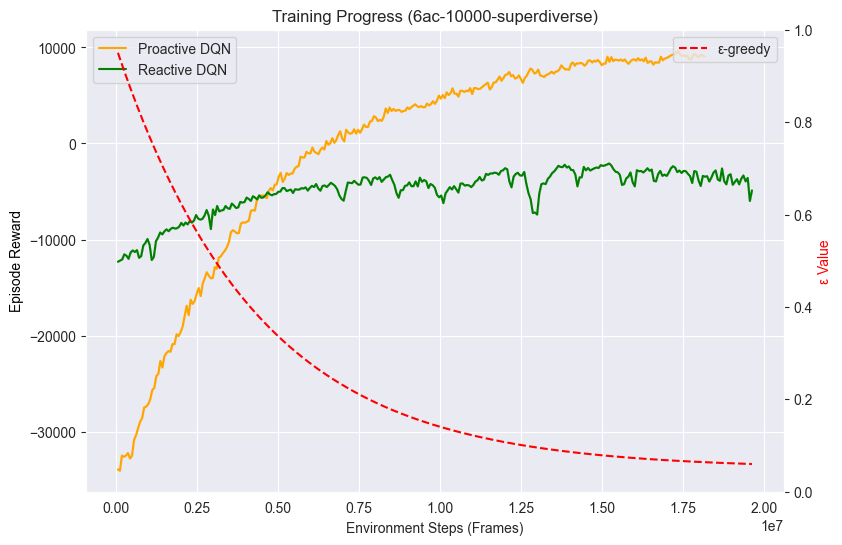

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import seaborn as sns
sns.set_style("darkgrid")
from matplotlib.animation import PillowWriter

###################################
# User parameters
###################################
master_folders = ["../2-archive-runs"]  # List of master folders to process
target_folder = "11-run"
target_scenario = "6ac-10000-superdiverse"
shown_seeds = []  # Only show these seeds, empty list means show all seeds
SMOOTHEDING_WINDOW = 1

def smooth(data, window=4):
    """Apply a simple moving average smoothing."""
    if isinstance(data, (float, np.float64)):
        return data
    if window > 1 and len(data) >= window:
        return np.convolve(data, np.ones(window)/window, mode='valid')
    return data

# Initialize agent data dictionary
agent_data = {}
colors = {'proactive': 'orange', 'myopic': 'blue', 'reactive': 'green', 'drl-greedy': 'red'}
labels = {
    'proactive': 'DQN Proactive-U',
    'myopic': 'DQN Proactive-N', 
    'reactive': 'DQN Reactive'
}

# Loop through each master folder to load data
for master_folder in master_folders:
    if not os.path.exists(master_folder):
        print(f"Skipping - The master folder '{master_folder}' does not exist.")
        continue

    save_folder = os.path.join(master_folder, target_folder)
    if not os.path.exists(save_folder):
        print(f"Target folder '{save_folder}' does not exist.")
        continue

    scenario_path = os.path.join(save_folder, target_scenario)
    numpy_path = os.path.join(scenario_path, "numpy")

    if not os.path.exists(numpy_path):
        print(f"Skipping {target_scenario} - no numpy folder found")
        continue

    # Find all numpy files in the directory
    numpy_files = [f for f in os.listdir(numpy_path) if f.endswith('.npy')]
    
    if not numpy_files:
        print(f"No .npy files found in {numpy_path}")
        continue

    # Process training data
    for file in numpy_files:
        if 'test_rewards' in file:
            continue
            
        if 'runs_seed_' in file and not 'steps' in file:
            agent_type = file.split('_runs_seed_')[0]
            data_type = 'runs'
        elif 'steps_runs_seed_' in file:
            agent_type = file.split('_steps_runs_seed_')[0]
            data_type = 'steps'
        else:
            continue
            
        if agent_type not in agent_data:
            agent_data[agent_type] = {'runs': [], 'steps': [], 'seeds': set()}
            
        data = np.load(os.path.join(numpy_path, file))
        seed = int(file.split('_seed_')[1].split('.')[0])
        
        # Skip if seed not in shown_seeds (if shown_seeds is not empty)
        if shown_seeds and seed not in shown_seeds:
            continue
            
        if data_type == 'runs':
            agent_data[agent_type]['runs'].append(data)
        else:
            agent_data[agent_type]['steps'].append(data)
        agent_data[agent_type]['seeds'].add(seed)

# Create the GIF
gif_path = f"training_curve_{target_scenario}-loose-axis.gif"
writer = PillowWriter(fps=10)

# Set up the figure with specified size and two y-axes
fig, ax1 = plt.subplots(figsize=(9, 6))
ax2 = ax1.twinx()  # Create second y-axis sharing same x-axis

# Set up the writer
writer.setup(fig, gif_path, dpi=100)

# Get total number of datapoints
total_points = 0
for agent_type in ['proactive', 'reactive']:
    if agent_type in agent_data:
        data = agent_data[agent_type]
        if len(data['runs']) > 0:
            min_length = min(len(run) for run in data['runs'])
            total_points = max(total_points, min_length)

# Set number of frames and calculate step size
NUM_FRAMES = 100  # Doubled from 50 to 100
step_size = total_points // NUM_FRAMES

# Pre-calculate epsilon values aligned with steps
epsilon_values = 0.9 * np.exp(-5 * np.arange(total_points) / total_points) + 0.05  # Ensure same number of points as total_points

for frame_idx in range(1, NUM_FRAMES + 1):
    ax1.clear()
    ax2.clear()
    
    current_points = frame_idx * step_size
    
    # Plot training data in specified order
    plot_order = ['proactive', 'reactive']
    for agent_type in plot_order:
        if agent_type not in agent_data:
            continue

        data = agent_data[agent_type]
        if len(data['runs']) == 0 or len(data['steps']) == 0:
            continue

        # Find minimum length and truncate arrays
        min_length = min(len(run) for run in data['runs'])
        runs_array = np.array([run[:min_length] for run in data['runs']])
        steps_array = np.array([steps[:min_length] for steps in data['steps']])

        # Calculate statistics
        mean = runs_array.mean(axis=0)
        std = runs_array.std(axis=0)
        steps_mean = steps_array.mean(axis=0).astype(int)

        # Apply smoothing
        smooth_window = SMOOTHEDING_WINDOW
        mean_sm = smooth(mean, smooth_window)[:current_points]
        std_sm = smooth(std, smooth_window)[:current_points]
        steps_sm = steps_mean[:len(mean_sm)]

        ax1.plot(steps_sm, mean_sm, color=colors.get(agent_type, 'gray'), label=f"{agent_type.capitalize()} DQN")
        ax1.fill_between(steps_sm, mean_sm - std_sm, mean_sm + std_sm, alpha=0.2, color=colors.get(agent_type, 'gray'))

    # Plot epsilon values aligned with steps
    if len(epsilon_values) > 0:
        current_epsilon_values = epsilon_values[:current_points]
        ax2.plot(steps_sm, current_epsilon_values, '--', color='red', label="ε-greedy")  # Use steps_sm as x-axis

    ax1.set_xlabel("Environment Steps (Frames)")
    ax1.set_ylabel("Episode Reward", color='black')
    ax2.set_ylabel("ε Value", color='red')
    
    # Move second y-axis to the right
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    
    ax2.set_ylim(0, 1)  # Static y-axis limits for epsilon
    ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])  # Add evenly spaced ticks
    ax2.grid(False)  # Remove gridlines for epsilon axis
    ax1.grid(True)   # Keep gridlines for reward axis

    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    plt.title(f"Training Progress ({target_scenario})")

    # Save the current frame to the writer
    writer.grab_frame()

# Finish the writing process
writer.finish()

print(f"GIF saved at {gif_path}")


GIF saved at training_curve_6ac-10000-superdiverse-semi-fixed-axis.gif


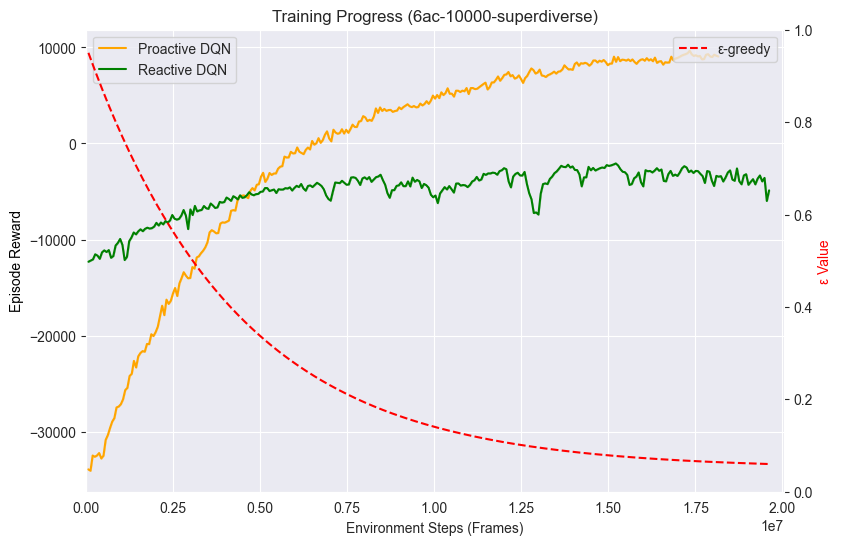

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import seaborn as sns
sns.set_style("darkgrid")
from matplotlib.animation import PillowWriter

###################################
# User parameters
###################################
master_folders = ["../2-archive-runs"]  # List of master folders to process
target_folder = "11-run"
target_scenario = "6ac-10000-superdiverse"
shown_seeds = []  # Only show these seeds, empty list means show all seeds
SMOOTHEDING_WINDOW = 1

def smooth(data, window=4):
    """Apply a simple moving average smoothing."""
    if isinstance(data, (float, np.float64)):
        return data
    if window > 1 and len(data) >= window:
        return np.convolve(data, np.ones(window)/window, mode='valid')
    return data

# Initialize agent data dictionary
agent_data = {}
colors = {'proactive': 'orange', 'myopic': 'blue', 'reactive': 'green', 'drl-greedy': 'red'}
labels = {
    'proactive': 'DQN Proactive-U',
    'myopic': 'DQN Proactive-N', 
    'reactive': 'DQN Reactive'
}

# Loop through each master folder to load data
for master_folder in master_folders:
    if not os.path.exists(master_folder):
        print(f"Skipping - The master folder '{master_folder}' does not exist.")
        continue

    save_folder = os.path.join(master_folder, target_folder)
    if not os.path.exists(save_folder):
        print(f"Target folder '{save_folder}' does not exist.")
        continue

    scenario_path = os.path.join(save_folder, target_scenario)
    numpy_path = os.path.join(scenario_path, "numpy")

    if not os.path.exists(numpy_path):
        print(f"Skipping {target_scenario} - no numpy folder found")
        continue

    # Find all numpy files in the directory
    numpy_files = [f for f in os.listdir(numpy_path) if f.endswith('.npy')]
    
    if not numpy_files:
        print(f"No .npy files found in {numpy_path}")
        continue

    # Process training data
    for file in numpy_files:
        if 'test_rewards' in file:
            continue
            
        if 'runs_seed_' in file and not 'steps' in file:
            agent_type = file.split('_runs_seed_')[0]
            data_type = 'runs'
        elif 'steps_runs_seed_' in file:
            agent_type = file.split('_steps_runs_seed_')[0]
            data_type = 'steps'
        else:
            continue
            
        if agent_type not in agent_data:
            agent_data[agent_type] = {'runs': [], 'steps': [], 'seeds': set()}
            
        data = np.load(os.path.join(numpy_path, file))
        seed = int(file.split('_seed_')[1].split('.')[0])
        
        # Skip if seed not in shown_seeds (if shown_seeds is not empty)
        if shown_seeds and seed not in shown_seeds:
            continue
            
        if data_type == 'runs':
            agent_data[agent_type]['runs'].append(data)
        else:
            agent_data[agent_type]['steps'].append(data)
        agent_data[agent_type]['seeds'].add(seed)

# Create the GIF
gif_path = f"training_curve_{target_scenario}-semi-fixed-axis.gif"
writer = PillowWriter(fps=10)

# Set up the figure with specified size and two y-axes
fig, ax1 = plt.subplots(figsize=(9, 6))
ax2 = ax1.twinx()  # Create second y-axis sharing same x-axis

# Set up the writer
writer.setup(fig, gif_path, dpi=100)

# Get total number of datapoints
total_points = 0
for agent_type in ['proactive', 'reactive']:
    if agent_type in agent_data:
        data = agent_data[agent_type]
        if len(data['runs']) > 0:
            min_length = min(len(run) for run in data['runs'])
            total_points = max(total_points, min_length)

# Set number of frames and calculate step size
NUM_FRAMES = 100  # Doubled from 50 to 100
step_size = total_points // NUM_FRAMES

# Pre-calculate epsilon values aligned with steps
epsilon_values = 0.9 * np.exp(-5 * np.arange(total_points) / total_points) + 0.05  # Ensure same number of points as total_points

# Calculate the final x-axis limits
final_steps = None
for agent_type in ['proactive', 'reactive']:
    if agent_type in agent_data:
        data = agent_data[agent_type]
        if len(data['steps']) > 0:
            min_length = min(len(run) for run in data['runs'])
            steps_array = np.array([steps[:min_length] for steps in data['steps']])
            steps_mean = steps_array.mean(axis=0).astype(int)
            if final_steps is None or len(steps_mean) > len(final_steps):
                final_steps = steps_mean

for frame_idx in range(1, NUM_FRAMES + 1):
    ax1.clear()
    ax2.clear()
    
    current_points = frame_idx * step_size
    
    # Plot training data in specified order
    plot_order = ['proactive', 'reactive']
    for agent_type in plot_order:
        if agent_type not in agent_data:
            continue

        data = agent_data[agent_type]
        if len(data['runs']) == 0 or len(data['steps']) == 0:
            continue

        # Find minimum length and truncate arrays
        min_length = min(len(run) for run in data['runs'])
        runs_array = np.array([run[:min_length] for run in data['runs']])
        steps_array = np.array([steps[:min_length] for steps in data['steps']])

        # Calculate statistics
        mean = runs_array.mean(axis=0)
        std = runs_array.std(axis=0)
        steps_mean = steps_array.mean(axis=0).astype(int)

        # Apply smoothing
        smooth_window = SMOOTHEDING_WINDOW
        mean_sm = smooth(mean, smooth_window)[:current_points]
        std_sm = smooth(std, smooth_window)[:current_points]
        steps_sm = steps_mean[:len(mean_sm)]

        ax1.plot(steps_sm, mean_sm, color=colors.get(agent_type, 'gray'), label=f"{agent_type.capitalize()} DQN")
        ax1.fill_between(steps_sm, mean_sm - std_sm, mean_sm + std_sm, alpha=0.2, color=colors.get(agent_type, 'gray'))

    # Plot epsilon values aligned with steps
    if len(epsilon_values) > 0:
        current_epsilon_values = epsilon_values[:current_points]
        ax2.plot(steps_sm, current_epsilon_values, '--', color='red', label="ε-greedy")  # Use steps_sm as x-axis

    ax1.set_xlabel("Environment Steps (Frames)")
    ax1.set_ylabel("Episode Reward", color='black')
    ax2.set_ylabel("ε Value", color='red')
    
    # Move second y-axis to the right
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    
    # Set fixed x-axis limits
    ax1.set_xlim(0, final_steps[-1])
    
    ax2.set_ylim(0, 1)  # Static y-axis limits for epsilon
    ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])  # Add evenly spaced ticks
    ax2.grid(False)  # Remove gridlines for epsilon axis
    ax1.grid(True)   # Keep gridlines for reward axis

    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    plt.title(f"Training Progress ({target_scenario})")

    # Save the current frame to the writer
    writer.grab_frame()

# Finish the writing process
writer.finish()

print(f"GIF saved at {gif_path}")


Epsilon decay: 0.9 * exp(-5 * t/T) + 0.05
Actual epsilon decay parameter: 5
GIF saved at training_curve_6ac-10000-superdiverse-fixed-axis.gif
Final frame saved as training_curve.png


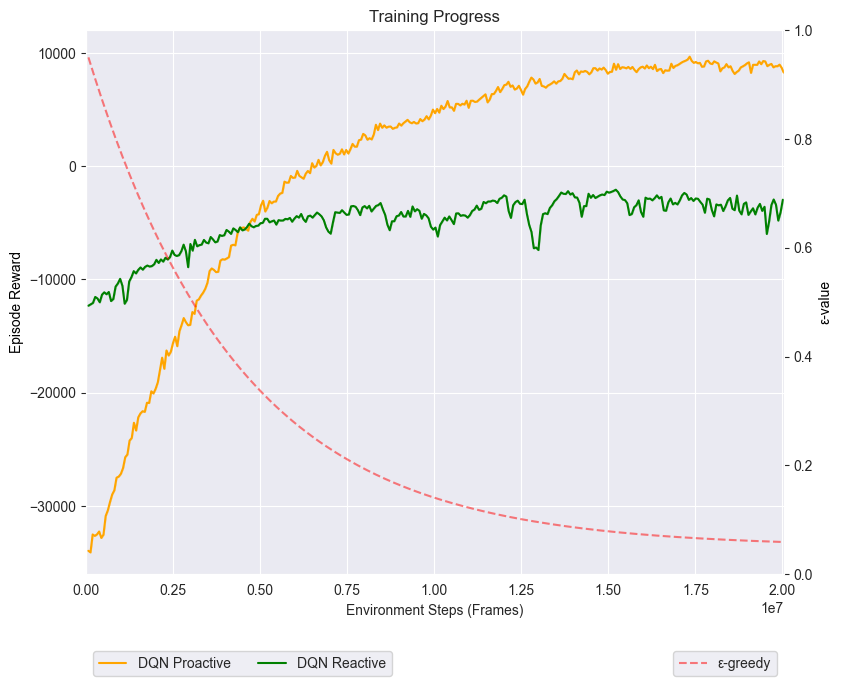

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import seaborn as sns
sns.set_style("darkgrid")
from matplotlib.animation import PillowWriter

###################################
# User parameters
###################################
master_folders = ["../2-archive-runs"]  # List of master folders to process
target_folder = "11-run"
target_scenario = "6ac-10000-superdiverse"
shown_seeds = []  # Only show these seeds, empty list means show all seeds
SMOOTHEDING_WINDOW = 1
SHOW_EPSILON = True  # Whether to show epsilon line and axis

def smooth(data, window=4):
    """Apply a simple moving average smoothing."""
    if isinstance(data, (float, np.float64)):
        return data
    if window > 1 and len(data) >= window:
        return np.convolve(data, np.ones(window)/window, mode='valid')
    return data

# Initialize agent data dictionary
agent_data = {}
colors = {'proactive': 'orange', 'myopic': 'blue', 'reactive': 'green', 'drl-greedy': 'red'}
labels = {
    'proactive': 'DQN Proactive',
    'myopic': 'DQN Proactive-N', 
    'reactive': 'DQN Reactive'
}

# Loop through each master folder to load data
for master_folder in master_folders:
    if not os.path.exists(master_folder):
        print(f"Skipping - The master folder '{master_folder}' does not exist.")
        continue

    save_folder = os.path.join(master_folder, target_folder)
    if not os.path.exists(save_folder):
        print(f"Target folder '{save_folder}' does not exist.")
        continue

    scenario_path = os.path.join(save_folder, target_scenario)
    numpy_path = os.path.join(scenario_path, "numpy")

    if not os.path.exists(numpy_path):
        print(f"Skipping {target_scenario} - no numpy folder found")
        continue

    # Find all numpy files in the directory
    numpy_files = [f for f in os.listdir(numpy_path) if f.endswith('.npy')]
    
    if not numpy_files:
        print(f"No .npy files found in {numpy_path}")
        continue

    # Process training data
    for file in numpy_files:
        if 'test_rewards' in file:
            continue
            
        if 'runs_seed_' in file and not 'steps' in file:
            agent_type = file.split('_runs_seed_')[0]
            data_type = 'runs'
        elif 'steps_runs_seed_' in file:
            agent_type = file.split('_steps_runs_seed_')[0]
            data_type = 'steps'
        else:
            continue
            
        if agent_type not in agent_data:
            agent_data[agent_type] = {'runs': [], 'steps': [], 'seeds': set()}
            
        data = np.load(os.path.join(numpy_path, file))
        seed = int(file.split('_seed_')[1].split('.')[0])
        
        # Skip if seed not in shown_seeds (if shown_seeds is not empty)
        if shown_seeds and seed not in shown_seeds:
            continue
            
        if data_type == 'runs':
            agent_data[agent_type]['runs'].append(data)
        else:
            agent_data[agent_type]['steps'].append(data)
        agent_data[agent_type]['seeds'].add(seed)

# Create the GIF
gif_path = f"training_curve_{target_scenario}-fixed-axis.gif"
writer = PillowWriter(fps=10)

# Set up the figure with specified size and two y-axes
fig, ax1 = plt.subplots(figsize=(9, 8))
if SHOW_EPSILON:
    ax2 = ax1.twinx()  # Create second y-axis sharing same x-axis

# Adjust subplot parameters to give specified padding
plt.subplots_adjust(bottom=0.2)  # Increase bottom margin to make room for legend

# Set up the writer
writer.setup(fig, gif_path, dpi=100)

# Get total number of datapoints and calculate y-axis limits
total_points = 0
min_reward = -36_000
max_reward = 12_000
for agent_type in ['proactive', 'reactive']:
    if agent_type in agent_data:
        data = agent_data[agent_type]
        if len(data['runs']) > 0:
            min_length = min(len(run) for run in data['runs'])
            total_points = max(total_points, min_length)
            runs_array = np.array([run[:min_length] for run in data['runs']])
            mean = runs_array.mean(axis=0)
            std = runs_array.std(axis=0)
            min_reward = min(min_reward, np.min(mean - std))
            max_reward = max(max_reward, np.max(mean + std))

# Set number of frames and calculate step size
NUM_FRAMES = 100  # Doubled from 50 to 100
step_size = total_points // NUM_FRAMES

# Pre-calculate epsilon values aligned with steps
if SHOW_EPSILON:
    epsilon_decay_param = 5  # The decay parameter in the exponential
    epsilon_values = 0.9 * np.exp(-epsilon_decay_param * np.arange(total_points) / total_points) + 0.05  # Ensure same number of points as total_points
    print(f"Epsilon decay: 0.9 * exp(-{epsilon_decay_param} * t/T) + 0.05")
    print(f"Actual epsilon decay parameter: {epsilon_decay_param}")

# Calculate the final x-axis limits
final_steps = None
for agent_type in ['proactive', 'reactive']:
    if agent_type in agent_data:
        data = agent_data[agent_type]
        if len(data['steps']) > 0:
            min_length = min(len(run) for run in data['runs'])
            steps_array = np.array([steps[:min_length] for steps in data['steps']])
            steps_mean = steps_array.mean(axis=0).astype(int)
            if final_steps is None or len(steps_mean) > len(final_steps):
                final_steps = steps_mean

   
# First create the animation frames
for frame_idx in range(1, NUM_FRAMES + 1):
    ax1.clear()
    if SHOW_EPSILON:
        ax2.clear()

    # Calculate current points and ensure the last frame includes all data
    if frame_idx == NUM_FRAMES:
        current_points = total_points
    else:
        current_points = frame_idx * step_size

    # Plot training data in specified order
    plot_order = ['proactive', 'reactive']
    for agent_type in plot_order:
        if agent_type not in agent_data:
            continue

        data = agent_data[agent_type]
        if len(data['runs']) == 0 or len(data['steps']) == 0:
            continue

        # Find minimum length and truncate arrays
        min_length = min(len(run) for run in data['runs'])
        runs_array = np.array([run[:min_length] for run in data['runs']])
        steps_array = np.array([steps[:min_length] for steps in data['steps']])

        # Calculate statistics
        mean = runs_array.mean(axis=0)
        std = runs_array.std(axis=0)
        steps_mean = steps_array.mean(axis=0).astype(int)

        # Apply smoothing
        smooth_window = SMOOTHEDING_WINDOW
        mean_sm = smooth(mean, smooth_window)[:current_points]
        std_sm = smooth(std, smooth_window)[:current_points]
        steps_sm = steps_mean[:len(mean_sm)]  # Ensure steps align with smoothed values

        ax1.plot(steps_sm, mean_sm, color=colors.get(agent_type, 'gray'), label=labels[agent_type])
        ax1.fill_between(steps_sm, mean_sm - std_sm, mean_sm + std_sm, alpha=0.2, color=colors.get(agent_type, 'gray'))

    # Plot epsilon values aligned with steps
    if SHOW_EPSILON and len(epsilon_values) > 0:
        current_epsilon_values = epsilon_values[:len(steps_sm)]  # Align with steps_sm
        ax2.plot(steps_sm, current_epsilon_values, '--', color='red', alpha=0.5, label="ε-greedy")

    ax1.set_xlabel("Environment Steps (Frames)")
    ax1.set_ylabel("Episode Reward", color='black')
    if SHOW_EPSILON:
        ax2.set_ylabel("ε-value", color='black')
        # Move second y-axis to the right
        ax2.yaxis.set_label_position("right")
        ax2.yaxis.tick_right()

    # Set fixed axis limits
    ax1.set_xlim(0, final_steps[-1])
    ax1.set_ylim(min_reward, max_reward)  # Fixed y-axis limits for rewards

    if SHOW_EPSILON:
        ax2.set_ylim(0, 1)  # Static y-axis limits for epsilon
        ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])  # Add evenly spaced ticks
        ax2.grid(False)  # Remove gridlines for epsilon axis
    ax1.grid(True)   # Keep gridlines for reward axis

    # Place legends at bottom in 2 columns
    ax1.legend(loc="lower left", bbox_to_anchor=(0.0, -0.2), ncol=2)
    if SHOW_EPSILON:
        ax2.legend(loc="lower right", bbox_to_anchor=(1.0, -0.2))

    plt.title(f"Training Progress")

    # Save the current frame to the writer
    writer.grab_frame()

# Add NUM_FRAMES additional frames of the final state
for _ in range(NUM_FRAMES):
    writer.grab_frame()  # This will add the last frame again

# Finish the writing process
writer.finish()

# Save final frame as PNG
plt.savefig('training_curve.png', bbox_inches='tight', dpi=1000)

print(f"GIF saved at {gif_path}")
print("Final frame saved as training_curve.png")
